# Rice Leaf Disease - Data Analysis Report

### Dataset Overview

* 119 images, 3 classes: Bacterial Leaf Blight (40), Brown Spot (40), Leaf Smut (39)

### Key Characteristics

* Small size → 119 images
* Balanced classes (~40 each)
* RGB images, varied lighting & orientation

### Challenges

* Limited data → risk of overfitting
* Visual similarity between classes
* Background & angle variations

### Preprocessing & Data Augmentation

* Resized to uniform size
* Normalized pixel values
* Shuffling & batching
* Random flips & rotations to simulate real-world variation.

### Insights

* Dataset is small but usable with augmentation
* Preprocessing ensures consistency
* Transfer learning may boost performance


In [4]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [5]:
#Set all the constants(Hyperparameters)

BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNEL = 3
EPOCHS = 20
from google.colab import drive
drive.mount('/content/drive')

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Data',
    seed =123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Mounted at /content/drive
Found 119 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

### Label
This part shows the labels corresponding to the images in the batch. It's a 1D tensor with a shape of (32), indicating the label for each image in the batch. The labels seem to be integers, ranging from 0 to 2

In [7]:
for image_batch, label_batch in dataset.take(1):
    print("Image Batch Shape :", image_batch.shape)
    print("Single Image :", image_batch[0])
    print("Label Image numpy :",label_batch.numpy())

Image Batch Shape : (32, 224, 224, 3)
Single Image : tf.Tensor(
[[[233.49777 218.49777 211.49777]
  [233.44055 221.93385 213.4361 ]
  [226.11383 212.11383 202.1183 ]
  ...
  [223.88623 205.88623 201.88623]
  [227.06563 210.06563 202.93379]
  [226.6228  209.6228  200.62727]]

 [[233.5067  218.5067  211.5067 ]
  [231.57167 217.55827 212.06497]
  [231.62053 214.62053 207.62053]
  ...
  [226.      209.      201.4933 ]
  [227.      210.      202.93497]
  [226.1161  209.1161  201.1161 ]]

 [[234.13393 221.13393 215.13393]
  [230.93562 215.93562 210.93562]
  [232.51115 217.51115 212.51115]
  ...
  [226.      209.      201.51115]
  [225.68806 208.68806 201.68806]
  [226.36877 211.81561 203.     ]]

 ...

 [[234.      219.      214.     ]
  [233.64287 218.64287 213.64287]
  [232.51117 219.51117 211.51117]
  ...
  [227.56679 208.56679 201.56679]
  [229.4244  210.4244  203.4244 ]
  [228.51117 209.51117 202.51117]]

 [[234.87051 219.87051 214.87051]
  [233.43999 218.43999 213.43999]
  [234.55096 2

In [8]:
len(class_names)

3

# EDA :-
* Visualize some of the images from our dataset

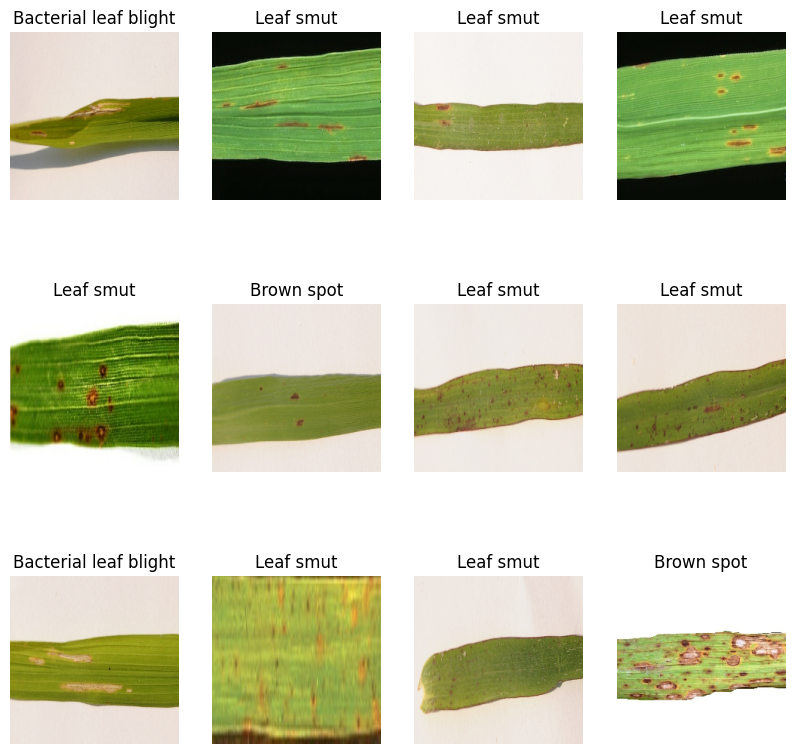

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset

## Dataset should be bifurcated into 3 subsets,namely:

* Training: Dataset to be used while training
* Validation: Dataset to be tested against while training
* Test: Dataset to be tested against after we trained a model

In [10]:
total_batches = len(dataset)

train_size = max(1, int(0.7 * total_batches))
val_size = max(1, int(0.2 * total_batches))
test_size = total_batches - train_size - val_size

# Adjust again if needed
if test_size <= 0:
    test_size = 1
    train_size = total_batches - val_size - test_size

# Split dataset
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

# Print sizes
print(f"Train batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Train batches: 2
Validation batches: 1
Test batches: 1


# Building the Model

#### Creating a Layer for Resizing and Normalization Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model

#### You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Changed from layers.preprocessing.Resizing
  layers.Rescaling(1./255), # Changed from layers.preprocessing.Rescaling
])

# Data Augmentation Report
Why Used:

#### The dataset has only  119 images(3 classes: 40 + 40 + 39),which is very small of deep learning.

#### Without augmentation, the model may:

* Overfit to training data
* Fail to generalize to new images
* Perform poorly on validation/test sets

In [13]:
from tensorflow.keras import layers
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [14]:
for batch in val_ds.take(1):
    print("Validation batch found.")

for images, labels in val_ds.take(1):
    print(f"Validation batch shape: {images.shape}")

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Validation batch found.
Validation batch shape: (32, 224, 224, 3)


In [15]:
print(f"Train batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")

Train batches: 2
Validation batches: 1


# Model Architeture

#### We use a CNN coupled with a Softmax Activation in the output layer. We also add the initial layers for resizing normalization and Data Augmentation.

In [17]:
n_classes=3

model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)),
    resize_and_rescale,
    data_augmentation,   # 👈 Augmentation yaha lagao

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.3),   # 👈 Overfitting avoid karega

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),   # 👈 Regularization
    layers.Dense(n_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [18]:
print(f"Length of train_ds: {len(train_ds)}")
print(f"Length of val_ds: {len(val_ds)}")
print(f"Length of test_ds: {len(test_ds)}")

if len(val_ds) == 0:
    print("Warning: val_ds is empty. Validation metrics will not be available.")

Length of train_ds: 2
Length of val_ds: 1
Length of test_ds: 1


In [19]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model

#### We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [20]:
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # Use this if your labels are integers
    metrics=['accuracy']
)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=85,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3125 - loss: 1.4449 - val_accuracy: 0.3125 - val_loss: 3.7831
Epoch 2/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step - accuracy: 0.2812 - loss: 3.0786 - val_accuracy: 0.3125 - val_loss: 1.1149
Epoch 3/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3438 - loss: 1.0928 - val_accuracy: 0.5625 - val_loss: 1.0745
Epoch 4/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3958 - loss: 1.0857 - val_accuracy: 0.4062 - val_loss: 1.0696
Epoch 5/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4688 - loss: 1.0411 - val_accuracy: 0.5625 - val_loss: 1.0137
Epoch 6/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 0.5938 - loss: 1.0248 - val_accuracy: 0.2812 - val_loss: 1.7046
Epoch 7/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4375 - loss: 1.4808 - val_accuracy: 0.4688 - val_loss: 1.0008
Epoch 8/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.4792 - loss: 0.9961 - val_accuracy: 0.3125 - val_loss: 1.0566
Epoch 

In [22]:
scores  = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8696 - loss: 0.2956


In [24]:
model.save("model.h5")

## Plotting the Accuracy and Loss Curves

In [25]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 85, 'steps': 2}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [26]:
print("Available history keys:", history.history.keys())
if len(val_ds) == 0:
    print("⚠️ Warning: Validation dataset is empty. No validation accuracy/loss will be recorded.")
history.history['loss'][:5] # show loss for first 5 epochs

Available history keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


[1.606007695198059,
 2.6543116569519043,
 1.096510887145996,
 1.0783922672271729,
 1.0422701835632324]

In [27]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

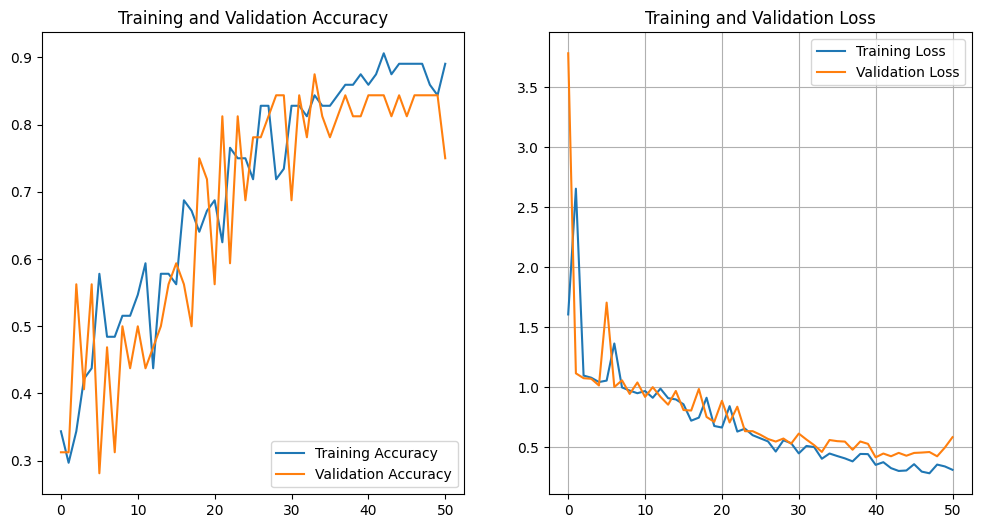

In [28]:
acc = history.history['accuracy']
val_acc = history.history.get('val_accuracy')  # use .get() in case it's None

loss = history.history['loss']
val_loss = history.history.get('val_loss')

epochs_range = range(len(acc))  # will automatically match the number of trained epochs

plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
if val_acc:
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
if val_loss:
    plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.grid(True)
plt.show()

## Run predication on a sample image

In [29]:
model = tf.keras.models.load_model('model.h5')

first image to predict
actual label: Bacterial leaf blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
predicted label: Bacterial leaf blight


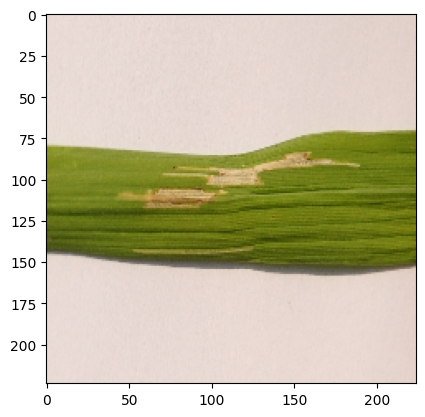

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Infence Report

### Why Used

To Test model perfomance on unseen images.

### What it does

* Predicts classes for new images
* Gives confidence scores
* Compares actual vs predicted

### Benefits

* Checks real-world accuracy
* Validates Predictions
* Measure confidence

# Function for inference

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


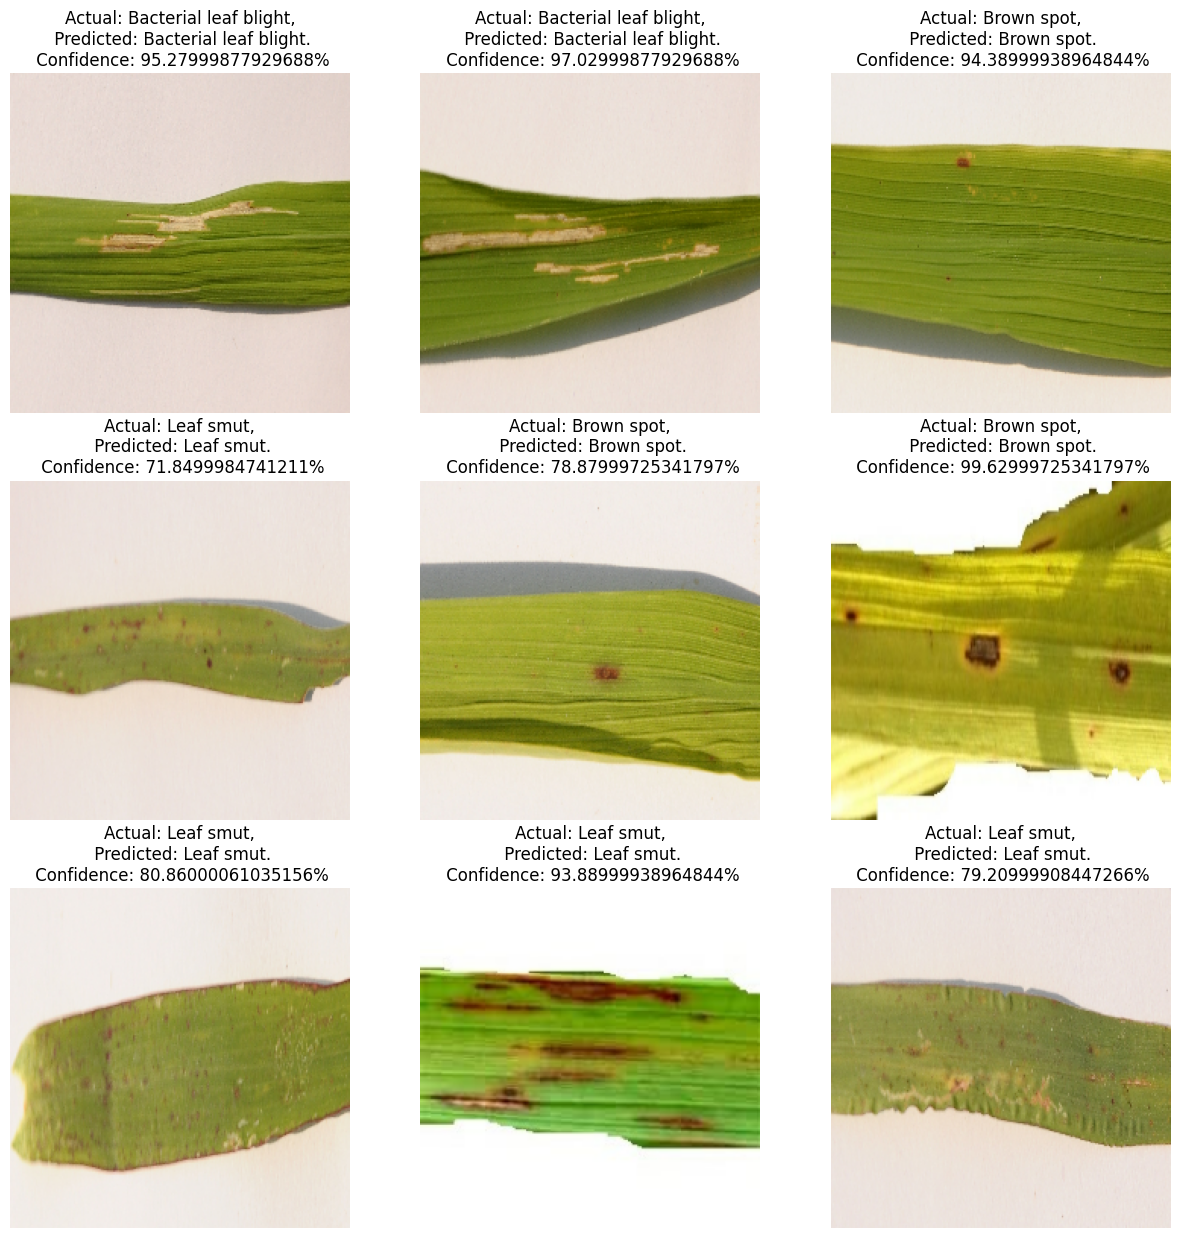

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [33]:
model.save("Plant_leaf_diseases_detection_model.h5")